In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import signal

### Constants

In [2]:
fs = 48000
N = 2048
K = 25

### Exercise 8.9

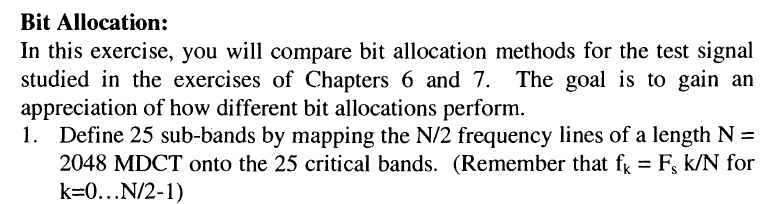

In [3]:
def bark(f): #Mapping to Bark Scale (25 subbands)
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

def get_subband_index(f):
    return 1 + int(bark(f))

def bin_to_subband_index(k, fs=48000, N=2048):
    return 1 + int(bark(k * fs / N))

In [4]:
print(f"Bin {0} is equivalent to sub-band {bin_to_subband_index(0, fs, N)}")
print(f"Bin {512} is equivalent to sub-band {bin_to_subband_index(512, fs, N)}")
print(f"Bin {1023} is equivalent to sub-band {bin_to_subband_index(1023, fs, N)}")

Bin 0 is equivalent to sub-band 1
Bin 512 is equivalent to sub-band 24
Bin 1023 is equivalent to sub-band 25


In [5]:
k_map = {k:0 for k in range(1, K+1)}

for bin in range(N//2): 
    k = bin_to_subband_index(bin, fs, N)
    k_map[k] = k_map[k] + 1

k_map.values()

dict_values([5, 4, 5, 4, 5, 5, 6, 6, 7, 7, 9, 10, 11, 15, 17, 22, 26, 31, 36, 43, 52, 66, 96, 171, 365])

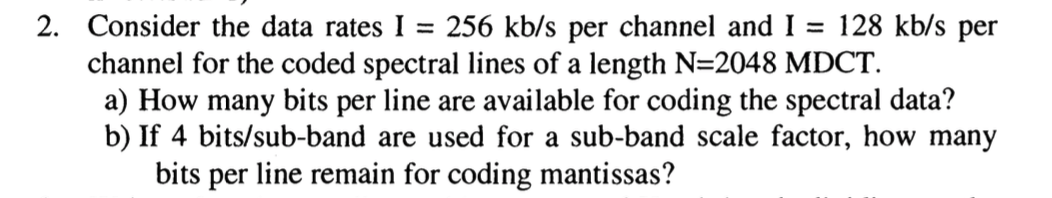

In [6]:
def R_k(data_rate, fs): # Average number of bits per coded sample
    return data_rate / fs


def block_bits_per_channel(R_k, N) : # Total number of bits in an MDCT block
    return R_k * N / 2

In [7]:
I_1 = 256000 # Data Rate 1
I_2 = 128000 # Data Rate 2

# Total number of bits
print(f"Total number of bits available (256 kb/s) = {int(block_bits_per_channel(R_k(I_1, fs), N))}")
print(f"Total number of bits available (128 kb/s) = {int(block_bits_per_channel(R_k(I_2, fs), N))}")

# Bits per line
bits_per_line = int(block_bits_per_channel(R_k(I_1, fs), N))*2/N
print(f"Bits per line (256 kb/s) = {bits_per_line}")

bits_per_line = int(block_bits_per_channel(R_k(I_2, fs), N))*2/N
print(f"Bits per line (128 kb/s) = {bits_per_line}")

# Bits per line after subtracting scale bits
scale_bits = 4
scale_bits_per_block = 4*K
print(f"\nRemoving {scale_bits} scale bits per sub-band... Total removed = {scale_bits_per_block}")

bits_per_line = int(block_bits_per_channel(R_k(I_1, fs), N) - scale_bits_per_block)*2/N
print(f"Remaining bits per line for mantissas (256 kb/s) = {bits_per_line}")

bits_per_line = int(block_bits_per_channel(R_k(I_2, fs), N) - scale_bits_per_block)*2/N
print(f"Remaining bits per line for mantissas (128 kb/s) = {bits_per_line}")

Total number of bits available (256 kb/s) = 5461
Total number of bits available (128 kb/s) = 2730
Bits per line (256 kb/s) = 5.3330078125
Bits per line (128 kb/s) = 2.666015625

Removing 4 scale bits per sub-band... Total removed = 100
Remaining bits per line for mantissas (256 kb/s) = 5.2353515625
Remaining bits per line for mantissas (128 kb/s) = 2.568359375


### Signal from chapters 6 and 7

In [8]:
class MDCT():
    def __init__(self, N: int, window: np.ndarray):
        K = N//2
        self.n_0 = ((N/2) + 1)/2

        A = np.zeros((K,N))
        for k in range(K):
            for n in range(N):
                A[k,n] = np.cos((2*np.pi/N)*(n + self.n_0)*(k+1/2))

        self.N = N
        self.window = window
        self.A_1 = A[:,:N//2]
        self.A_2 = A[:,N//2:]
        self.B_1 = (4/N)*self.A_1.T
        self.B_2 = (4/N)*self.A_2.T

        self.A = A
        self.B = (4/N)*A.T

        if window.shape[0] != N:
            raise ValueError(f"Window is not the same size as N! Window size: {window.shape[0]}")

    def _preprocess(self, x: np.ndarray):
        L = len(x)
        self.frames = L//(self.N//2) + 1
        r = L%(self.N//2)
        return np.pad(x, (self.N // 2, self.N // 2 - r), 'constant', constant_values=(0,0))


    def mdct(self, x: np.ndarray):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = self.A @ (frame * self.window)

        return X

    def imdct(self, X: np.ndarray):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += (self.B @ X[:,frame_idx]) * self.window
            
        return x_padded[self.N//2:-self.N//2]
    
    def mdct_pre_twiddle(self):
        return np.exp(-2j * np.pi * np.arange(self.N) / (2*self.N))

    def mdct_post_twiddle(self):
        return np.exp(-2j * np.pi * self.n_0 * (np.arange(self.N//2) + 0.5) / self.N)


    def mdct_via_fft(self, x):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = np.real(
                self.mdct_post_twiddle() * np.fft.fft(frame * self.window * self.mdct_pre_twiddle())[:self.N//2]
            )
        
        return X 
    
    def imdct_pre_twiddle(self):
        return np.exp(2j * np.pi * self.n_0 * np.arange(self.N) / self.N)

    def imdct_post_twiddle(self):
        return np.exp(2j * np.pi * (np.arange(self.N) + self.n_0) / (2*self.N))
    
    def imdct_via_ifft(self, X):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += \
            np.real(np.fft.ifft(np.concatenate((X[:,frame_idx], -X[::-1,frame_idx])) * self.imdct_pre_twiddle()) * \
            self.imdct_post_twiddle()) * 2 * self.window
            
        return x_padded[self.N//2:-self.N//2]

In [9]:
def sine_window(N):
    M = N//2
    w = np.zeros((N,1))

    for n in range(N-M):
        w[n] = np.sin((np.pi/2)*(n+1/2)/(N-M))
        
    for n in range(N-M,M):
        w[n] = 1

    for n in range(M,N):
        w[n] = np.sin((np.pi/2)*(N - n - 1/2)/(N-M))

    return w.reshape(-1)

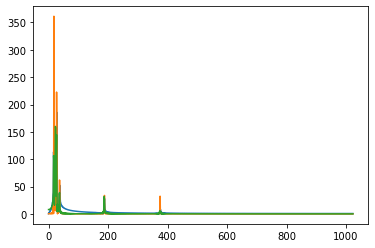

In [10]:
n = np.arange(N)
T = N/fs
t = np.linspace(0, T, N)

A0 = 0.6
A1 = 0.55
A2 = 0.55
A3 = 0.15
A4 = 0.1
A5 = 0.05


x = A0 * np.cos(2 * np.pi * n * 440/fs) \
  + A1 * np.cos(2 * np.pi * n * 554/fs) \
  + A2 * np.cos(2 * np.pi * n * 660/fs) \
  + A3 * np.cos(2 * np.pi * n * 880/fs) \
  + A4 * np.cos(2 * np.pi * n * 4400/fs) \
  + A5 * np.cos(2 * np.pi * n * 8800/fs)

my_mdct = MDCT(N, sine_window(N))

X_mdct = abs(my_mdct.mdct(x))

mdct_bins = np.arange(X_mdct.shape[0])
mdct_freqs = (mdct_bins * fs / N)

plt.plot(X_mdct)

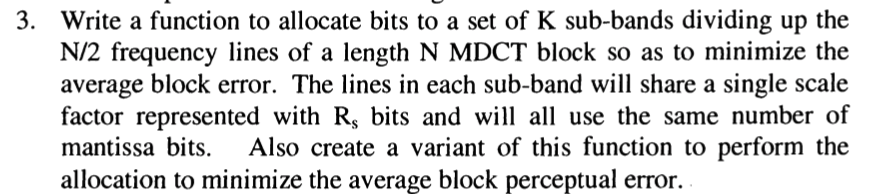

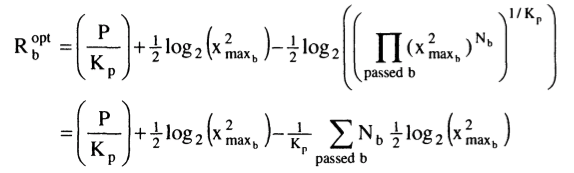

#### Uniform allocation

In [11]:
def uniform_allocation(total_bits, scale_bits_per_block, K):
    initial_allocation = (total_bits - scale_bits_per_block) // K * np.ones((K))
    remaining_bits = (total_bits - scale_bits_per_block) % K
    initial_allocation[np.random.permutation(K)[:remaining_bits]] += 1
    
    return initial_allocation

In [12]:
I_1 = 256000 # Data Rate 1
I_2 = 128000 # Data Rate 2

# Bits per line after subtracting scale bits
scale_bits = 4
scale_bits_per_block = 4*K
print(f"\nRemoving {scale_bits} scale bits per sub-band... Total removed = {scale_bits_per_block}")
uniform_alloc = uniform_allocation(int(block_bits_per_channel(R_k(I_1, fs), N) - 100), scale_bits_per_block, K)
print(f"Uniform bit allocation  per sub-band for mantissas (256 kb/s) = {uniform_alloc}")

uniform_alloc = uniform_allocation(int(block_bits_per_channel(R_k(I_2, fs), N) - 100), scale_bits_per_block, K)
print(f"Uniform bit allocation per sub-band for mantissas (128 kb/s) = {uniform_alloc}")


Removing 4 scale bits per sub-band... Total removed = 100
Uniform bit allocation  per sub-band for mantissas (256 kb/s) = [210. 210. 210. 210. 211. 211. 211. 211. 210. 210. 210. 211. 211. 210.
 210. 210. 210. 210. 211. 211. 210. 211. 211. 210. 211.]
Uniform bit allocation per sub-band for mantissas (128 kb/s) = [101. 101. 101. 101. 101. 101. 101. 101. 102. 101. 101. 102. 101. 101.
 101. 102. 101. 101. 102. 101. 101. 101. 101. 102. 101.]


#### Optimal error bit allocation

In [13]:
def bit_allocation(K_p, P, R_s, N_b, xmax_b):
    xmax_b = xmax_b / np.min(xmax_b)
    avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2))/K_p
    buffer = np.array((P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg)
        
    return buffer

In [14]:
def bit_allocation_greedy(K_p, P, R_s, N_b, xmax_b):
    avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2))/K_p
    buffer = np.array((P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg)
    
    positives = np.ones_like(buffer)
    while np.any(buffer < 0):
        positives[np.nonzero(buffer < 0)[0]] = 0
        K_p = np.count_nonzero(positives)
        
        avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2) * positives) / K_p
        buffer = np.array((P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg) * positives
        
    return buffer


In [15]:
def waterfilling(x_max_b, Nb, total_bits):
    t_sup = np.max(x_max_b)
    threshold = t_sup
    t_inf = np.min(x_max_b)
    
    sub_band_bits = np.zeros_like(x_max_b)
    bits_allocated = 0
    x_max_b_sorted_idxs = np.argsort(x_max_b)[::-1]
    
    while bits_allocated < total_bits:
        for i in x_max_b_sorted_idxs:
            for j in range(Nb[i]):
                if x_max_b[i] >= threshold and bits_allocated < total_bits:
                    sub_band_bits[i] += 1
                    bits_allocated += 1
            
        if threshold > t_inf:
            threshold -= 1
        else:
            threshold = t_inf
            
    return sub_band_bits # num_sub_bands x 1 

In [16]:
Nb = np.array(list(k_map.values()))
total_bits = int(block_bits_per_channel(R_k(I_1, fs), N) - 100) # Total bits for mantissas per block

In [17]:
df = pd.DataFrame({'bin': range(1024), 'mdct': X_mdct[:, 1]})
df["subband"] = df["bin"].apply(bin_to_subband_index)
df.drop(columns = ["bin"], inplace = True)
df['x_k'] = df['mdct'].apply(lambda x: 2 ** np.ceil(np.log2(x)))
df['scale_bits'] = df['mdct'].apply(lambda x: np.ceil(np.log2(x)))
x_max_b = df.groupby(by=["subband"]).max()["scale_bits"].to_numpy()
x_max_b_sorted_idxs = np.argsort(x_max_b)[::-1]

In [18]:
x_max_b = df.groupby(by=["subband"]).max()["x_k"].to_numpy()
allocation = bit_allocation(K, total_bits, scale_bits, np.array(list(k_map.values())), x_max_b)

print("Total bits available:", total_bits, "\n")
print( "Bit allocation (normal) per subband: \n\n",allocation, "\n")
print ("\nTotal number of allocated bits:",np.sum(allocation))

Total bits available: 5361 

Bit allocation (normal) per subband: 

 [  96.88   86.88  106.88  102.88  141.88  136.88  148.88  142.88  130.88
  109.88  118.88  116.88  123.88  136.88  131.88  156.88  176.88  542.88
  334.88  218.88  202.88 1102.88  526.88  217.88   46.88] 


Total number of allocated bits: 5361.000000000001


In [19]:
x_max_b = df.groupby(by=["subband"]).max()["x_k"].to_numpy()
allocation = bit_allocation_greedy(K, total_bits, scale_bits, np.array(list(k_map.values())), x_max_b)

print("Total bits available:", total_bits, "\n")
print( "Bit allocation (normal) per subband: \n\n",allocation, "\n")
print ("\nTotal number of allocated bits:",np.sum(allocation))

Total bits available: 5361 

Bit allocation (normal) per subband: 

 [256.05 256.05 266.05 272.05 301.05 296.05 298.05 292.05 270.05 249.05
 238.05 226.05 223.05 196.05 171.05 146.05 126.05 442.05 184.05  -0.
  -0.   652.05  -0.    -0.    -0.  ] 


Total number of allocated bits: 5361.0


In [20]:
sub_band_bits = waterfilling(x_max_b, Nb, total_bits)
sub_band_bits.sum(), sub_band_bits

(5361.0,
 array([   0.,    0.,    0.,    0., 2315., 1035.,  474.,   84.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  463.,
           0.,    0.,    0.,  990.,    0.,    0.,    0.]))

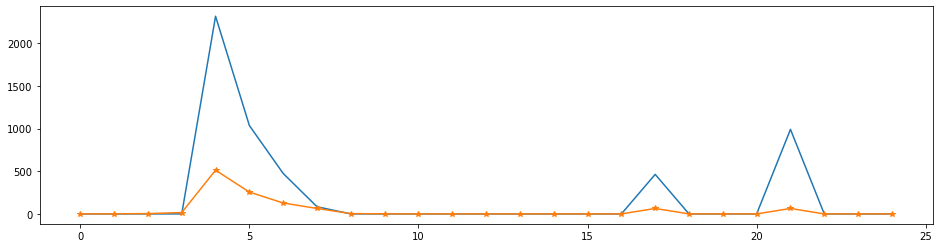

In [21]:
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(waterfilling(x_max_b, Nb, total_bits))
plt.plot(x_max_b, "*-")

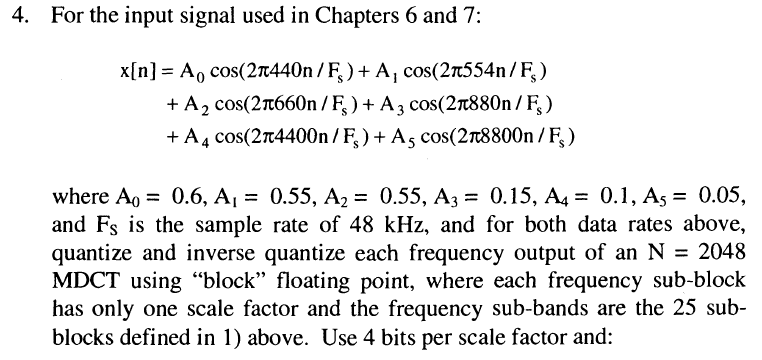

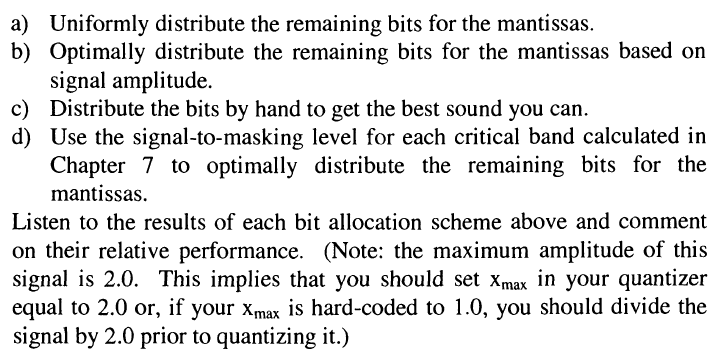

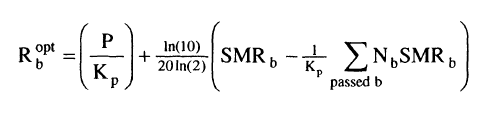

In [22]:
def bit_allocation_perceptual_greedy(K_p, P, N_b, SMR_b):
    
    avg = np.sum(np.array(N_b) * SMR_b)/K_p
    buffer = np.array((P/K_p) + (np.log(10) / (20 * np.log(2))) * (SMR_b - avg))
    
    positives = np.ones_like(buffer)
    while np.any(buffer < 0):
        positives[np.nonzero(buffer < 0)[0]] = 0
        K_p = np.count_nonzero(positives)
        
        avg = np.sum(np.array(N_b) * SMR_b * positives)/K_p
        buffer = np.array((P/K_p) + (np.log(10) / (20 * np.log(2))) * (SMR_b - avg)) * positives
        
    return buffer

In [23]:
def bit_allocation_perceptual(K_p, P, N_b, SMR_b):
    SMR_b = np.array(N_b) * SMR_b / np.min(SMR_b)
    avg = np.sum(SMR_b)/K_p
    buffer = np.array((P/K_p) + (np.log(10) / (20 * np.log(2))) * (SMR_b - avg))
        
    return buffer

In [24]:
w = sine_window(N)
x_w = x[:N] * w
X_fft = np.fft.fftshift(np.fft.fft(x_w, n=N))
omega_fft = np.fft.fftshift(np.fft.fftfreq(N))

In [25]:
X_mdct_total = np.zeros_like(X_mdct[:, 1])
X_mdct_total[:X_mdct_total.shape[0]//2] = X_mdct[:X_mdct_total.shape[0]//2, 0] + X_mdct[X_mdct_total.shape[0]//2:, 1]
X_mdct_total[X_mdct_total.shape[0]//2:] = X_mdct[:X_mdct_total.shape[0]//2, 1] + X_mdct[X_mdct_total.shape[0]//2:, 2]
X_mdct_total

array([0.3308931 , 1.96565103, 1.31143332, ..., 0.07746073, 0.07717877,
       0.07745639])

In [26]:
def spl_peaks(X, N_fft, N_w):
    bw_factor = N_fft / (2 * N_w)
    norm = (N_w * N_fft / 8)
    
    X_db = 20 * np.log10(X)
    peaks, _ = signal.find_peaks(X_db, height=0.1, prominence=25)
    SPL = np.zeros(peaks.shape)
    for i, p in enumerate(peaks):
        peak_energy = np.sum(np.abs(X[p - int(np.ceil(3 * bw_factor)):p + int(np.ceil(3 * bw_factor))]) ** 2) / norm
        SPL[i] = 96 + 10 * np.log10(peak_energy + np.finfo(float).eps)
    
    return SPL, peaks

def spl(X, N_fft, N_w):
    bw_factor = N_fft / (2 * N_w)
    norm = (N_w * N_fft / 8)
    
    print(X.shape[0])
    for i in range(X.shape[0]):
        print(f"i: {i}")
        print(f"i: {i}")
        lim_inf = i - int(np.ceil(3 * bw_factor))
        lim_sup = i + int(np.ceil(3 * bw_factor))
        if i < int(np.ceil(3 * bw_factor)):
            lim_inf = 0
        if i > X.shape[0] - int(np.ceil(3 * bw_factor)):
            lim_sup = -1
        print(f"lim_inf: {lim_inf}")
        print(f"lim_sup: {lim_sup}")
            
        peak_energy = np.sum(np.abs(X[lim_inf:lim_sup]) ** 2) / norm
        SPL[i] = 96 + 10 * np.log10(peak_energy + np.finfo(float).eps)
    
    return SPL

def spl_by_sample(X, N_fft, N_w):
    norm = (N_w * N_fft / 8)

    peak_energy = np.abs(X) ** 2 / norm
    return 96 + 10 * np.log10(peak_energy + np.finfo(float).eps)



In [27]:
def delta_tone_masking_noise(z, delta):
    return delta + z

def masking_model(bark, SPL, peaks, delta=15):
    sf_peaks = np.zeros((len(bark), len(bark)))
    
    teta = np.zeros_like(bark)
    for i in peaks:
        dz = bark - bark[i]
        teta[dz > 0] = 1
        
        # spreading function
        sf = ((-27 + 0.37 * np.max((SPL[i] - 40), 0) * teta) * np.abs(dz))
        
        # masking model
        sf_peaks[i,:] = np.maximum(SPL[i] + sf - delta_tone_masking_noise(bark[i], delta), 0)
     
    return sf_peaks

def calc_SMR(spl, z, mask, K=25, N=1024):
    z_values = np.linspace(0,K,N)
    mask_arg = np.argmin(np.abs(z_values-z))
    return spl-mask[mask_arg]

#Threshold in quiet
def hearing_threshold(mdct_freqs):
    mdct_freqs[0] = mdct_freqs[1]
    threshold = 3.64*(mdct_freqs/1000)**(-.8)-6.5*np.exp(-.6*(mdct_freqs/1000-3.3)**2)+10**(-3)*(mdct_freqs/1000)**4
    threshold_barks = bark(mdct_freqs)
#     plt.plot(threshold_barks, threshold)
    return (threshold_barks, threshold)

def higher_mask(mask_1, mask_2):
    return np.maximum(mask_1, mask_2)

In [28]:
# SPL = spl(X_mdct[:, 1], N, N)
SPL = spl_by_sample(X_mdct[:, 1], N, N)
SPL_peaks, peaks = spl_peaks(X_mdct[:, 1], N, N)
bark_freqs = bark(mdct_freqs)
# sf_peaks = masking_model(bark_freqs, SPL, peaks)

(1024,)


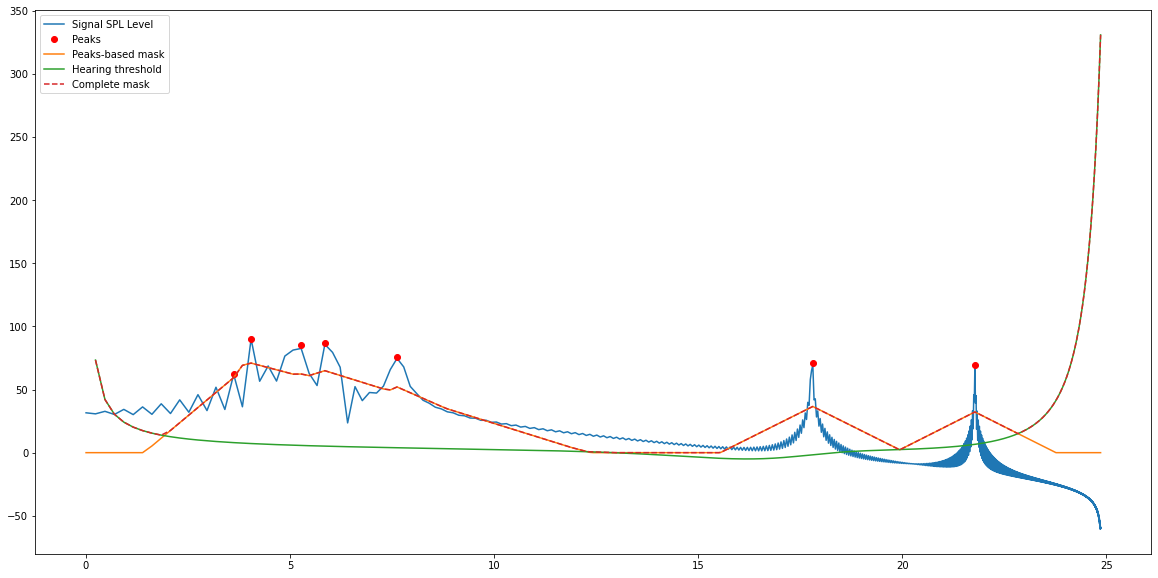

In [29]:
print(SPL.shape)

plt.figure(figsize=(20,10))
plt.plot(bark_freqs, SPL, label="Signal SPL Level")
plt.plot(bark_freqs[peaks], SPL_peaks, "ro", label="Peaks")
#plt.plot(bark_freqs, np.abs(X_mdct[:, 1]) ** 2)
mask = np.max(masking_model(bark_freqs, SPL, peaks), axis=0)
plt.plot(bark_freqs, mask, label = "Peaks-based mask")
t_bark, thres = hearing_threshold(mdct_freqs)
plt.plot(t_bark, thres, label="Hearing threshold")
complete_mask = higher_mask(thres, mask)
plt.plot(t_bark, complete_mask, "--", label="Complete mask")
plt.legend()

In [34]:
SMR = calc_SMR(SPL, bark_freqs, complete_mask)

df = pd.DataFrame({'bin': range(1024), 'smr': SMR})
df["subband"] = df["bin"].apply(bin_to_subband_index)
df.drop(columns = ["bin"], inplace = True)
# df['x_k'] = df['mdct'].apply(lambda x: 2 ** np.ceil(np.log2(x)))
# df['scale_bits'] = df['mdct'].apply(lambda x: np.ceil(np.log2(x)))
smr_b = df.groupby(by=["subband"]).max()["smr"].to_numpy()
#smr_b = 2 ** (smr_b/10)
bit_allocation_perceptual_greedy(K,total_bits,Nb,smr_b)
# sum(bit_allocation_perceptual(K,total_bits,Nb,smr_b))

array([209.74810383, 209.65423371, 209.65170671, 209.49975129,
       209.28692904, 209.3217362 , 209.36434558, 209.41156109,
       209.73182201, 209.93127235, 210.1562629 , 210.32553709,
       210.48407577, 210.9420941 , 211.24609054, 211.87703901,
       212.25218662, 209.62597831, 212.44543471, 214.71759461,
       216.28425828, 209.89391005, 219.93414869, 235.1638495 ,
       270.05007801])

In [37]:
k_map

{1: 5,
 2: 4,
 3: 5,
 4: 4,
 5: 5,
 6: 5,
 7: 6,
 8: 6,
 9: 7,
 10: 7,
 11: 9,
 12: 10,
 13: 11,
 14: 15,
 15: 17,
 16: 22,
 17: 26,
 18: 31,
 19: 36,
 20: 43,
 21: 52,
 22: 66,
 23: 96,
 24: 171,
 25: 365}

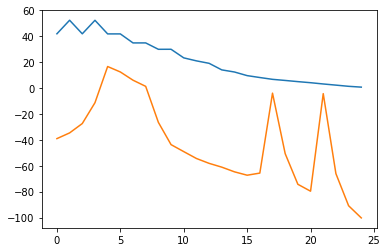

In [40]:
plt.plot(bit_allocation_perceptual(K,total_bits,Nb,smr_b) / Nb)
plt.plot(smr_b)

In [ ]:
from scipy.interpolate import interp1d

#number of steps N in z
N_z = 1000

#not used
def sum1(arr, alpha):
    return np.power(np.sum(np.power(arr,alpha)),1/alpha)

#max
def sum2(arr):
    return np.max(arr)

masks = []
for i in range(A.shape[-1]):
    masks.append(masking_model(bark(freq[i]),F[i],N_z)) #each frequency mask
#
# print(list(masks)[1])
masks = np.matrix(masks)#= np.concatenate(list(masks),0)
mask = np.zeros(masks.shape[-1])
for i in range(masks.shape[-1]):
    mask[i] = sum2(masks[:,i]) #combination of all masks

spl_fft_x = 10*np.log10((np.abs(X_w)**2/(N*N_fft/8))/E0)

#print(bark(f).shape[-1])
#print(t.shape[-1])

z_values = np.linspace(0,25,N_z)
mask_interp_z = interp1d(z_values,mask) #interpolation of mask for z values
threshold_interp_z = interp1d(bark(f),t) #interpolation of threshold for z values
#spl_fft_x_interp_z = interp1d(bark(omega*F_s), spl_fft_x, kind='quadratic')
omega_in_bark = bark(omega*F_s) #omegas of FFT in bark values

bits = np.zeros(N)
final_mask = np.zeros(N)
#print(z_values[:2])
print(threshold_interp_z(24.5))

for i in range(N):
    #combine threshold in silence with mask
    if omega_in_bark[i]>=.2 and omega_in_bark[i]<=24.575: final_mask[i] = sum2((threshold_interp_z(omega_in_bark[i]), mask_interp_z(omega_in_bark[i])))
    #bits of each frequency component
    bits[i] = max(np.ceil((spl_fft_x[i]-final_mask[i])/6),0) 

for i in range(freq.shape[-1]):
    print(f'SMR(f={freq[i]}): {calc_SMR(F[i],bark(freq[i]),mask)}')

fig, axs = plt.subplots(1, figsize=(16,4))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axs2 = axs.twinx()
axs2.set_ylabel('bits')
color='tab:red'
#axs.plot(omega_in_bark,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.plot(omega*F_s,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.set_xlim(20,10000)
#axs.set_xlim(0.2,24)
axs.scatter(freq,F, c='r', marker='.', label=r'$SPL(f_n)$ [From FFT]')
#axs.plot(omega_in_bark,final_mask, label='Mask+Threshold')
#axs2.plot(omega_in_bark, bits, label='bits', color=color)
axs.plot(omega*F_s,final_mask, label='Mask+Threshold')
axs2.plot(omega*F_s, bits, label='bits', color=color)
axs.set_ylim(-5,130)
axs.grid()
#axs.set_xlabel('Barks')
axs.set_xlabel('Hz')
axs.set_ylabel('SPL')
axs.legend()
axs2.tick_params(axis='y', labelcolor=color)

In [ ]:
F_s = 48000
n = np.arange(F_s+1)
f0 = 1000
x = np.sin(2*np.pi*f0*n/F_s)
N = 2048
N_fft = N*8

w = sin_w(N)
bw = 3*F_s/N

x_w = x[0:N]*w
print(x_w.shape[-1])

X_w = np.fft.fftshift(np.fft.fft(x_w,n=int(N_fft)))
omega = np.fft.fftshift(np.fft.fftfreq(X_w.shape[-1]))
print(f'Normalized area: {np.sum(np.square(np.abs(X_w[:int(N_fft/2)]))/(N**2*8/8))}')
max_norm_freq_comp = (np.max(np.square(np.abs(X_w))/(N**2/8)))
amp_3dB_arg = np.argmin(np.abs(np.square(np.abs(X_w))/(N**2/8)-max_norm_freq_comp/2))

###############################
# 6.12 Item 2
###############################
A = np.array([.6, .55, .55, .15, .1, .05])
freq = np.array([440, 554, 660, 880, 4400, 8800])
w = sin_w(N)
x = np.zeros(n.shape[-1])
for i in range(A.shape[-1]): x += A[i]*np.sin(2*np.pi*freq[i]*n/F_s)
x_w = x[0:N]*w

N_fft = N
bw = 3*F_s/N

def get_idx(f_array, f):
    return np.argmin(np.abs(f_array-f))

def spl(x, w, f_arr, N_fft, F_s, E0=10**(-9.6)):
    #print(f,N_fft,F_s)
    N = w.shape[-1]
    bw_factor = N_fft/(2*N)
    x_w = x[:N]*w
    X_w = np.fft.fftshift(np.fft.fft(x_w,n=N_fft))
    omega = np.fft.fftshift(np.fft.fftfreq(N_fft))
    idx = np.zeros(f_arr.shape[-1], dtype=int)
    for i in range(f_arr.shape[-1]):
        idx[i] = get_idx(omega*F_s,f_arr[i])
    F = np.array([10*np.log10(np.sum(np.abs(X_w[idx[i]-int(np.ceil(3*bw_factor)):idx[i]+int(np.ceil(3*bw_factor))])**2)/(N*N_fft/8)/E0) for i in range(f_arr.shape[-1])])
    return F


#reference amplitude
E0 = 10**(-96/10)

X_w = np.fft.fftshift(np.fft.fft(x_w,n=N_fft))
omega = np.fft.fftshift(np.fft.fftfreq(X_w.shape[-1]))

F = spl(x,w,freq,N_fft,F_s)

#Threshold in quiet (dB)
f = np.linspace(20, 20000, 1000)
t = 3.64*(f/1000)**(-.8)-6.5*np.exp(-.6*(f/1000-3.3)**2)+10**(-3)*(f/1000)**4

In [ ]:
from scipy.interpolate import interp1d

#number of steps N in z
N_z = 1000

#bark scale
def bark(f):
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

#spreading of masking
def spreading_f(dz,L):
    return (-27+.37*np.max(L-40,0)*np.heaviside(dz,1))*np.abs(dz)

def delta_tone_masking_noise(z):
    return 14.5+z#dB -> in text it's 14.5 but in the end of the chapter, to generate the chart, it was used delta=15 dB

#not used
def sum1(arr, alpha):
    return np.power(np.sum(np.power(arr,alpha)),1/alpha)

#max
def sum2(arr):
    return np.max(arr)

def calc_SMR(spl, z, mask, N=N_z):
    z_values = np.linspace(0,25,N)
    mask_arg = np.argmin(np.abs(z_values-z))
    return spl-mask[mask_arg]

def masking_model(z,L,N):
    mask = L+spreading_f(np.linspace(-z,25-z,N),L)-delta_tone_masking_noise(z)
    return mask

masks = []
for i in range(A.shape[-1]):
    masks.append(masking_model(bark(freq[i]),F[i],N_z)) #each frequency mask
#
# print(list(masks)[1])
masks = np.matrix(masks)#= np.concatenate(list(masks),0)
mask = np.zeros(masks.shape[-1])
for i in range(masks.shape[-1]):
    mask[i] = sum2(masks[:,i]) #combination of all masks

spl_fft_x = 10*np.log10((np.abs(X_w)**2/(N*N_fft/8))/E0)

#print(bark(f).shape[-1])
#print(t.shape[-1])

z_values = np.linspace(0,25,N_z)
mask_interp_z = interp1d(z_values,mask) #interpolation of mask for z values
threshold_interp_z = interp1d(bark(f),t) #interpolation of threshold for z values
#spl_fft_x_interp_z = interp1d(bark(omega*F_s), spl_fft_x, kind='quadratic')
omega_in_bark = bark(omega*F_s) #omegas of FFT in bark values

bits = np.zeros(N)
final_mask = np.zeros(N)
#print(z_values[:2])
print(threshold_interp_z(24.5))

for i in range(N):
    #combine threshold in silence with mask
    if omega_in_bark[i]>=.2 and omega_in_bark[i]<=24.575: final_mask[i] = sum2((threshold_interp_z(omega_in_bark[i]), mask_interp_z(omega_in_bark[i])))
    #bits of each frequency component
    bits[i] = max(np.ceil((spl_fft_x[i]-final_mask[i])/6),0) 

for i in range(freq.shape[-1]):
    print(f'SMR(f={freq[i]}): {calc_SMR(F[i],bark(freq[i]),mask)}')

fig, axs = plt.subplots(1, figsize=(16,4))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axs2 = axs.twinx()
axs2.set_ylabel('bits')
color='tab:red'
#axs.plot(omega_in_bark,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.plot(omega*F_s,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.set_xlim(20,10000)
#axs.set_xlim(0.2,24)
axs.scatter(freq,F, c='r', marker='.', label=r'$SPL(f_n)$ [From FFT]')
#axs.plot(omega_in_bark,final_mask, label='Mask+Threshold')
#axs2.plot(omega_in_bark, bits, label='bits', color=color)
axs.plot(omega*F_s,final_mask, label='Mask+Threshold')
axs2.plot(omega*F_s, bits, label='bits', color=color)
axs.set_ylim(-5,130)
axs.grid()
#axs.set_xlabel('Barks')
axs.set_xlabel('Hz')
axs.set_ylabel('SPL')
axs.legend()
axs2.tick_params(axis='y', labelcolor=color)